# Analyze result
モデルの予測性能などを評価するノートブック

In [28]:
%load_ext autoreload
%autoreload 2

In [9]:
import torch
import os
import csv 
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from src.score_prediction_models.docking_score_predictor import DockingScorePredictor
from src.data.dataloader import get_dataloader
from tqdm.notebook import tqdm
from matplotlib import cm

In [10]:
with open('../config/filepath.yml') as file:
    path_config = yaml.safe_load(file)

with open('../config/model.yml') as file:
    model_config = yaml.safe_load(file)

with open('../config/data.yml') as file:
    data_config = yaml.safe_load(file)

dude_dir = os.path.join('..', path_config['data']['DUD-E'])
alphafold_dir = os.path.join('..', path_config['data']['alphafold'])
smiles_dir = os.path.join('..', path_config['data']['smiles'])
output_dir = os.path.join('..', path_config['data']['plots'])
hist_dir = os.path.join('..', path_config['data']['hist'])
eval_dir = os.path.join('..', path_config['data']['eval'])
preprocessed_dir = os.path.join('..', path_config['data']['preprocessed'])
sample_dir = os.path.join('..', path_config['data']['samples'])
model_dir = os.path.join('..', path_config['data']['docking'])

ds_reg_output_dir = os.path.join(output_dir, 'ds_regression')



In [56]:
model_timestamp = '2024-12-23_14-28-07'
result_test_path = os.path.join(eval_dir, 'ds_regression', f"results_{model_timestamp}_test.csv")
result_train_path = os.path.join(eval_dir, 'ds_regression', f"results_{model_timestamp}_train.csv")

result_test_df = pd.read_csv(result_test_path)
result_train_df = pd.read_csv(result_train_path)

print(result_test_df.head())
print(result_train_df.head())

                                              SMILES Protein_ID  \
0  C[NH+](C)[C@H](CNC(=O)NNC(=O)c1cc(Br)c[nH]1)c1...        DYR   
1  Cc1ccc(-c2c[nH]nc2[C@@H]2CCCN(C(=O)C3([NH3+])C...        DYR   
2    C[C@@]12CC[C@H]3C[C@]1(C(=O)[O-])[NH2+]C[C@]32C        DYR   
3  C/C(=N/NC(=O)c1cc(O)ccc1O)c1cccc(NC(=O)c2csc3c...        DYR   
4        CS[C@H](C)/C([O-])=N/S(=O)(=O)c1cc(Br)ccc1C       ALDR   

   Actual_Docking_Score  Predicted_Docking_Score  
0             -6.285899                -2.109682  
1             -6.315050                -3.582389  
2             -5.237497                -2.624921  
3             -6.261746                -3.818731  
4             -7.496721                -6.190664  
                                              SMILES Protein_ID  \
0  Cc1c(C(=O)Nc2cc(C(F)(F)F)ccc2Cl)oc2c1/C(=N/NC(...       CDK2   
1    O=C(N/N=C/c1cccc(Br)c1)c1nn(Cc2ccc(Cl)cc2)cc1Br       DHI1   
2       CCCc1cc([O-])nc(SCC(=O)NCc2ccccc2Cn2cccn2)n1      CASP3   
3  NC(=O)[C@@H]1CCCN1C(

In [19]:
def plot_docking_scores_vs_predictions(df, output_dir, filename="docking_score_plot.png"):
    """
    Plots docking score predictions vs actual values with color coding for Protein IDs.

    Args:
        df (pd.DataFrame): DataFrame containing columns 'Protein_ID', 'Actual_Docking_Score', and 'Predicted_Docking_Score'.
        output_dir (str): Directory to save the plot.
        filename (str): Name of the output plot file. Defaults to 'docking_score_plot.png'.

    Saves:
        A scatter plot as a file in the specified directory.
    """
    # Unique Protein IDs and color map
    unique_protein_ids = df['Protein_ID'].unique()
    cmap = cm.get_cmap('tab10', len(unique_protein_ids))
    colors = {protein_id: cmap(i) for i, protein_id in enumerate(unique_protein_ids)}

    # Create the plot
    plt.figure(figsize=(10, 6))
    for protein_id in unique_protein_ids:
        subset = df[df['Protein_ID'] == protein_id]
        plt.scatter(
            subset["Actual_Docking_Score"],
            subset["Predicted_Docking_Score"],
            label=protein_id,
            color=colors[protein_id],
            alpha=0.7
        )
    
    corr = df["Actual_Docking_Score"].corr(df["Predicted_Docking_Score"])
    r2 = r2_score(df["Actual_Docking_Score"], df["Predicted_Docking_Score"])
    mse = mean_squared_error(df["Actual_Docking_Score"], df["Predicted_Docking_Score"])


    # Add diagonal lines
    plt.axline((0, 0), slope=1, color="red", linestyle="--", label="y = x")
    plt.axline((0, 0.5), slope=1, color="gray", linestyle="--", alpha=0.5, label="y = x + 0.5")
    plt.axline((0, -0.5), slope=1, color="gray", linestyle="--", alpha=0.5, label="y = x - 0.5")

    # Labels, title, and legend
    plt.xlabel("Actual Docking Score")
    plt.ylabel("Predicted Docking Score")
    plt.title("Docking Score Prediction vs Actual Values")
    plt.legend(title="Protein ID")
    plt.grid(True)

    # Adjust scale to match aspect ratio
    plt.gca().set_aspect('equal', adjustable='box')

    # Add metrics to the plot
    metrics_text = f"Pearson r: {corr:.2f}\nR2 Score: {r2:.2f}\nMSE: {mse:.2f}"
    plt.text(0.05, 0.95, metrics_text, fontsize=10, transform=plt.gca().transAxes,
             verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))

    # Save the plot
    os.makedirs(output_dir, exist_ok=True)  # Ensure output directory exists
    output_file = os.path.join(output_dir, filename)
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"Plot saved to: {output_file}")

    # Display the plot
    plt.show()

In [27]:
def plot_docking_score_heatmap(data, actual_col, predicted_col, x_label, y_label, title):
    """
    Plots a density heatmap for actual vs. predicted docking scores with additional reference lines.

    Args:
        data (pd.DataFrame): DataFrame containing the actual and predicted scores.
        actual_col (str): Column name for actual docking scores.
        predicted_col (str): Column name for predicted docking scores.
        x_label (str): Label for the x-axis.
        y_label (str): Label for the y-axis.
        title (str): Title for the plot.
    """
    actual_scores = data[actual_col]
    predicted_scores = data[predicted_col]

    # Determine plot range
    min_score = min(actual_scores.min(), predicted_scores.min())
    max_score = max(actual_scores.max(), predicted_scores.max())

    # Create the density heatmap
    plt.figure(figsize=(8, 6))
    sns.kdeplot(
        x=actual_scores,  # Swapped
        y=predicted_scores,  # Swapped
        cmap='Blues',
        fill=True,
        cbar=True
    )

    # Calculate and display metrics
    corr = data[actual_col].corr(data[predicted_col])
    r2 = r2_score(data[actual_col], data[predicted_col])
    mse = mean_squared_error(data[actual_col], data[predicted_col])

    metrics_text = f"Pearson r: {corr:.2f}\nR2 Score: {r2:.2f}\nMSE: {mse:.2f}"
    plt.text(0.05, 0.95, metrics_text, fontsize=10, transform=plt.gca().transAxes,
             verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))

    # Add y=x and x±0.5 lines
    x_vals = np.linspace(min_score, max_score, 100)
    plt.plot(x_vals, x_vals, color='red', linestyle='--', label='y=x')
    plt.plot(x_vals, x_vals + 0.5, color='gray', linestyle='--', label='y=x+0.5')
    plt.plot(x_vals, x_vals - 0.5, color='gray', linestyle='--', label='y=x-0.5')

    # Set axis labels and title
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    # Adjust scales to match
    plt.xlim(min_score, max_score)
    plt.ylim(min_score, max_score)

    # Add legend
    plt.legend()

    # Grid
    plt.grid(True)

    # Show the plot
    plt.show()

In [34]:
def plot_attn_map(csv_file, output_dir, filename="attn_map.png", row_range=None, col_range=None):
    """
    Plots the attention map for a given protein-ligand pair with optional range selection.

    Args:
        csv_file (str): Path to the CSV file containing attention weights.
        output_dir (str): Directory to save the plot.
        filename (str): Name of the output plot file. Defaults to 'attn_map.png'.
        row_range (tuple, optional): Range of rows to plot (start, end). Defaults to None (plot all rows).
        col_range (tuple, optional): Range of columns to plot (start, end). Defaults to None (plot all columns).

    Saves:
        A heatmap plot as a file in the specified directory.
    """
    # Load the attention weights from the CSV file
    attn_weights = pd.read_csv(csv_file, header=None)

    # Apply range selection if specified
    if row_range is not None:
        attn_weights = attn_weights.iloc[row_range[0]:row_range[1], :]
    if col_range is not None:
        attn_weights = attn_weights.iloc[:, col_range[0]:col_range[1]]

    # Create the plot
    plt.figure(figsize=(10, 6))
    sns.heatmap(attn_weights, cmap="viridis", cbar_kws={"label": "Attention Weight"})
    plt.title("Attention Map")
    plt.xlabel("Protein Sequence Tokens")
    plt.ylabel("Ligand SMILES Sequence Tokens")

    # Save the plot
    os.makedirs(output_dir, exist_ok=True)  # Ensure output directory exists
    output_file = os.path.join(output_dir, filename)
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"Plot saved to: {output_file}")

    # Display the plot
    plt.show()


## Global model の評価

In [5]:
global_timestamp = '2024-12-23_14-28-07'
global_eval_dir = os.path.join(eval_dir, 'ds_regression', global_timestamp)
global_result_test_path = os.path.join(eval_dir, 'ds_regression', global_timestamp, 'results_test.csv')
global_plot_dir = os.path.join(ds_reg_output_dir, global_timestamp)

global_result_test_df = pd.read_csv(global_result_test_path)

print(global_result_test_df.head())


                                              SMILES Protein_ID  \
0  C[NH+](C)[C@H](CNC(=O)NNC(=O)c1cc(Br)c[nH]1)c1...        DYR   
1  Cc1ccc(-c2c[nH]nc2[C@@H]2CCCN(C(=O)C3([NH3+])C...        DYR   
2    C[C@@]12CC[C@H]3C[C@]1(C(=O)[O-])[NH2+]C[C@]32C        DYR   
3  C/C(=N/NC(=O)c1cc(O)ccc1O)c1cccc(NC(=O)c2csc3c...        DYR   
4        CS[C@H](C)/C([O-])=N/S(=O)(=O)c1cc(Br)ccc1C       ALDR   

   Actual_Docking_Score  Predicted_Docking_Score  
0             -6.285899                -2.109682  
1             -6.315050                -3.582389  
2             -5.237497                -2.624921  
3             -6.261746                -3.818731  
4             -7.496721                -6.190664  


attention map を可視化
1. 結果の良いもの

Plot saved to: .././data/plots/ds_regression/2024-12-23_14-28-07/attn_map_ZINC63195390(best).png


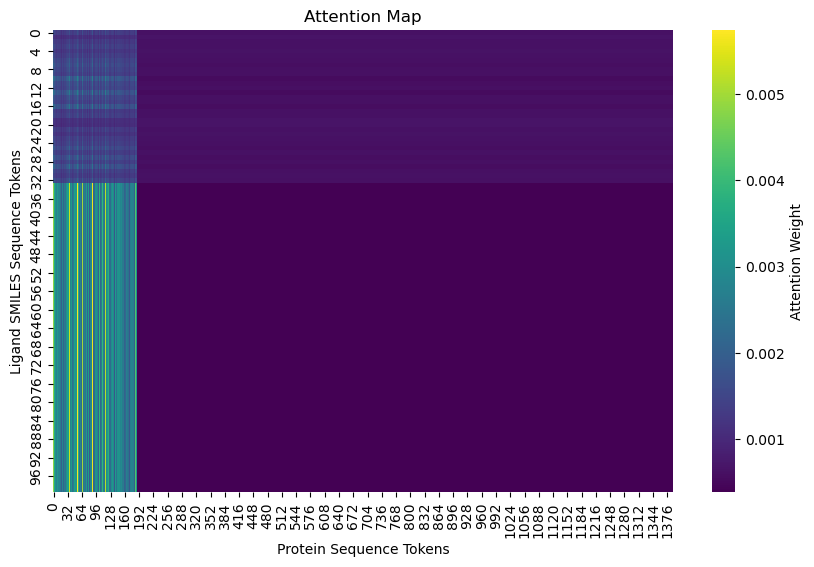

In [12]:
best_ligand = 'ZINC63195390'
attn_map_file = os.path.join(global_eval_dir , f"attn_map_0_{best_ligand}.csv")
plot_attn_map(attn_map_file, global_plot_dir, f"attn_map_{best_ligand}(best).png")

2. 結果の悪いもの

Plot saved to: .././data/plots/ds_regression/2024-12-23_14-28-07/attn_map_ZINC38794086(worst).png


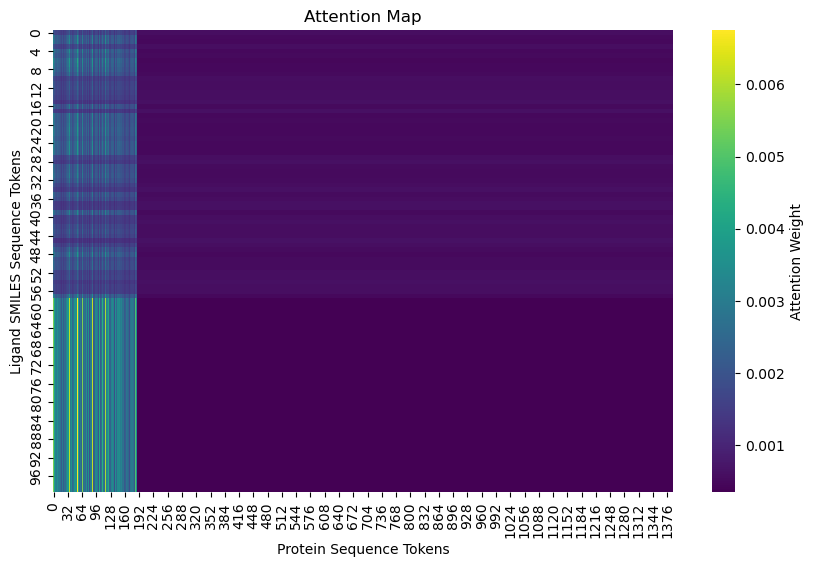

In [13]:
worst_ligand = 'ZINC38794086'
attn_map_file = os.path.join(global_eval_dir , f"attn_map_0_{worst_ligand}.csv")
plot_attn_map(attn_map_file, global_plot_dir, f"attn_map_{worst_ligand}(worst).png")

テストデータの予測値と実際の値をプロット

/tmp/ipykernel_773/3409123922.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(unique_protein_ids))


Plot saved to: .././data/plots/ds_regression/2024-12-28_22-17-43/docking_score_test_plot.png


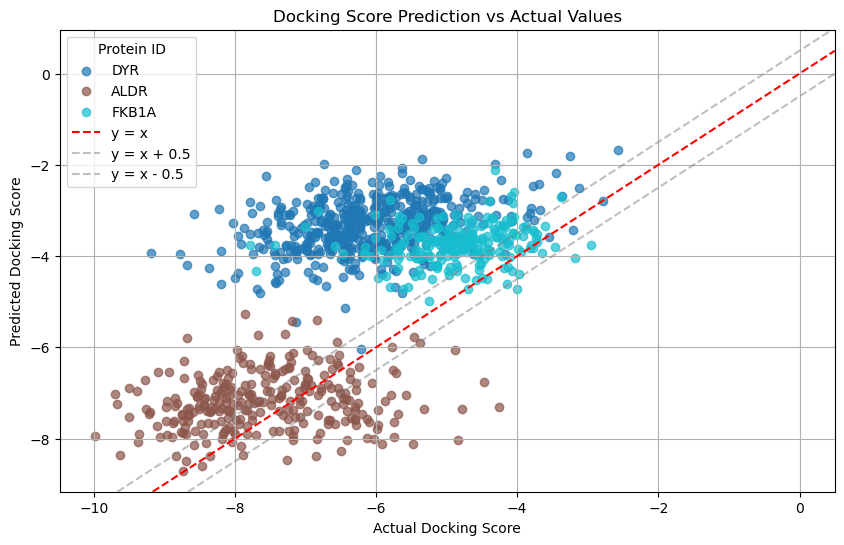

In [62]:
plot_docking_scores_vs_predictions(result_test_df, ds_reg_output_dir, filename="docking_score_test_plot.png")

相関係数と r2 値を計算

In [46]:
correration = result_test_df["Actual_Docking_Score"].corr(result_test_df["Predicted_Docking_Score"])
print(f"Correlation: {correration}")
r2 = r2_score(result_test_df["Actual_Docking_Score"], result_test_df["Predicted_Docking_Score"])
print(f"R2 Score: {r2}")

Correlation: 0.6114586839120323
R2 Score: -1.7617143142783953


最も回帰結果のよいものと悪いものを出力

best: ZINC63195390

worst: ZINC38794086

In [83]:
global_result_test_df["Score_Diff"] = abs(global_result_test_df["Actual_Docking_Score"] - global_result_test_df["Predicted_Docking_Score"])

best_match = global_result_test_df.loc[global_result_test_df['Score_Diff'].idxmin()]
worst_match = global_result_test_df.loc[global_result_test_df['Score_Diff'].idxmax()]

print(f"Best Match: {best_match}")
print(f"Worst Match: {worst_match}")

Best Match: SMILES                     C=CCNC(=O)NC(=O)CN1CCCC[C@H]1[C@@H](C)[NH3+]
Protein_ID                                                          DYR
Actual_Docking_Score                                          -2.787573
Predicted_Docking_Score                                       -2.795161
Score_Diff                                                     0.007588
Name: 998, dtype: object
Worst Match: SMILES                     O=S(=O)(NC[C@H]1NN[C@H](S(=O)(=O)Cc2ccccc2F)O1...
Protein_ID                                                               DYR
Actual_Docking_Score                                               -8.580854
Predicted_Docking_Score                                            -3.079079
Score_Diff                                                          5.501775
Name: 100, dtype: object


学習データの予測値と実際の値をプロット

/tmp/ipykernel_773/1450284897.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(unique_protein_ids))


Plot saved to: .././data/plots/ds_regression/docking_score_train_plot.png


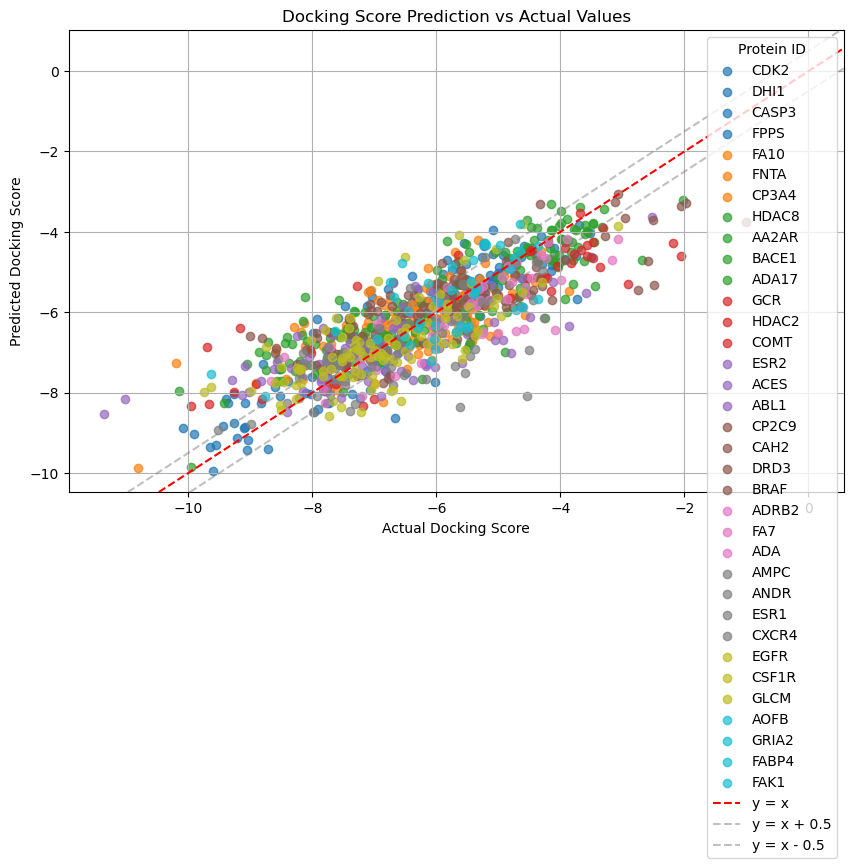

In [47]:
plot_docking_scores_vs_predictions(result_train_df, ds_reg_output_dir, filename="docking_score_train_plot.png")

相関係数とr2を計算

In [48]:
correration = result_train_df["Actual_Docking_Score"].corr(result_train_df["Predicted_Docking_Score"])
print(f"Correlation: {correration}")
r2 = r2_score(result_train_df["Actual_Docking_Score"], result_train_df["Predicted_Docking_Score"])
print(f"R2 Score: {r2}")

Correlation: 0.819224834807564
R2 Score: 0.6697942990876804


リガンド数上位三つのタンパクについてプロット

/tmp/ipykernel_773/1450284897.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(unique_protein_ids))


Plot saved to: .././data/plots/ds_regression/docking_score_top_3_proteins_train_plot.png


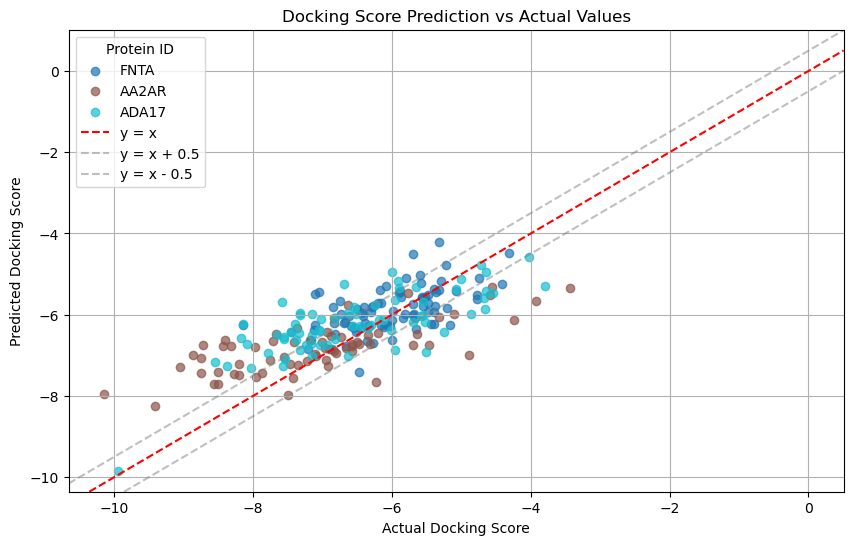

In [53]:
top_3_proteins = result_train_df.groupby('Protein_ID').size().sort_values(ascending=False).head(3).index
top_3_proteins_df = result_train_df[result_train_df['Protein_ID'].isin(top_3_proteins)]
plot_docking_scores_vs_predictions(top_3_proteins_df, ds_reg_output_dir, filename="docking_score_top_3_proteins_train_plot.png")

## local model の評価

In [24]:
local_timestamp = '2024-12-28_22-17-43'
local_eval_dir = os.path.join(eval_dir, 'ds_regression', local_timestamp)
local_result_test_path = os.path.join(eval_dir, 'ds_regression', local_timestamp, 'results_test.csv')
local_plot_dir = os.path.join(ds_reg_output_dir, local_timestamp)

local_result_test_df = pd.read_csv(local_result_test_path)

print(local_result_test_df.head())

                                              SMILES Protein_ID  \
0  Nc1c2c(-c3ccccc3F)nc(NCC[NH+]3CCCCC3)nc2nn1Cc1...       FNTA   
1  CCc1ccc(S(=O)(=O)N2CCC3(CC2)NCC[NH+]=C3NCc2ccc...       FNTA   
2  CC(C)S(=O)(=O)NC[C@@H](c1ccc(S(=O)(=O)C(C)C)cc...       FNTA   
3  c1ccc(Cn2c(SC[C@H]3CCCO3)nnc2C2CC[NH+](Cc3cccs...       FNTA   
4  CCOc1cc(/C=C2\SC(=S)N(CC)C2=O)cc(Br)c1O[C@@H](...       FNTA   

   Actual_Docking_Score  Predicted_Docking_Score  
0             -6.830777                -6.643064  
1             -6.520177                -5.600744  
2             -5.247583                -5.555860  
3             -5.503261                -5.648897  
4             -5.514993                -5.317862  


attention map を可視化
1. 結果の良いもの


Plot saved to: .././data/plots/ds_regression/2024-12-28_22-17-43/2024-12-28_22-17-43/attn_map_ZINC14537560(best).png


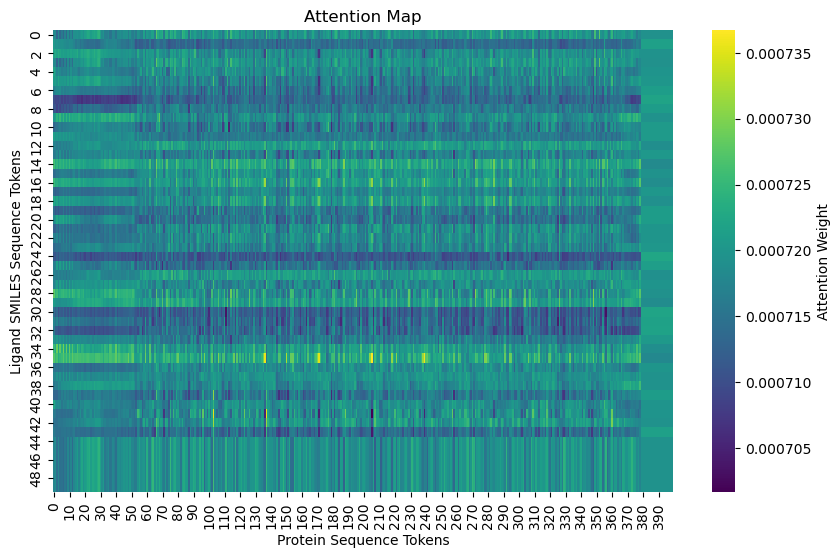

In [36]:
best_ligand = 'ZINC14537560'
attn_map_file = os.path.join(local_eval_dir , f"attn_map_0_{best_ligand}.csv")
plot_attn_map(attn_map_file, local_plot_dir, f"attn_map_{best_ligand}(best).png", row_range=(0, ), col_range=(0, 400))

2. 結果の悪いもの

Plot saved to: .././data/plots/ds_regression/2024-12-28_22-17-43/attn_map_ZINC36063486(worst).png


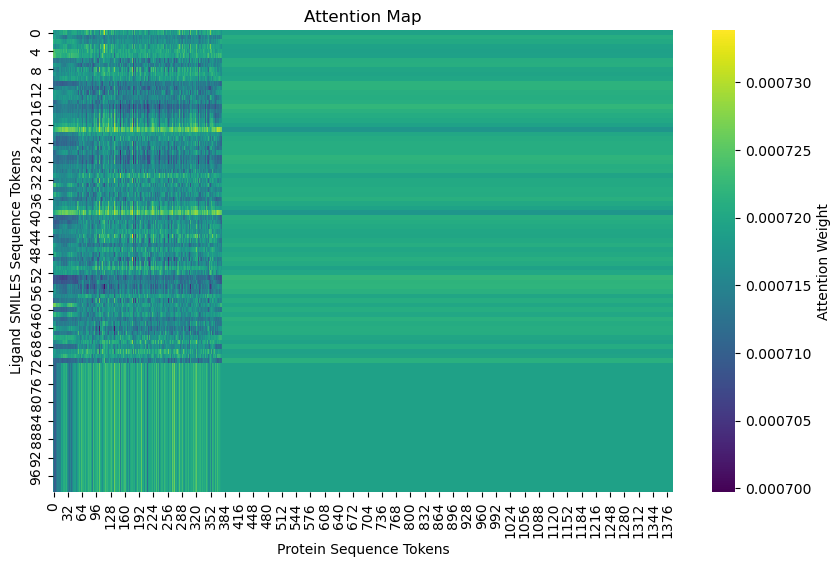

In [16]:
worst_ligand = 'ZINC36063486'
attn_map_file = os.path.join(local_eval_dir , f"attn_map_0_{worst_ligand}.csv")
plot_attn_map(attn_map_file, local_plot_dir, f"attn_map_{worst_ligand}(worst).png")

予測値と実際の値をプロット

/tmp/ipykernel_806/1952641928.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(unique_protein_ids))


Plot saved to: .././data/plots/ds_regression/2024-12-28_22-17-43/docking_score_test_plot.png


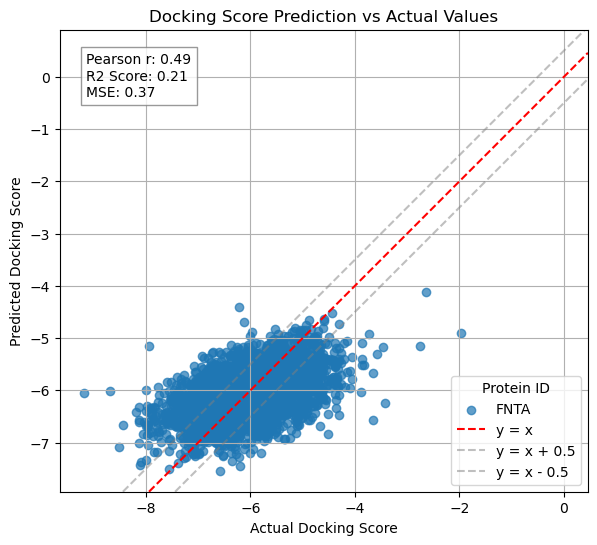

In [20]:
model_timestamp = '2024-12-28_22-17-43'

result_test_df = pd.read_csv(os.path.join(eval_dir, 'ds_regression', model_timestamp, "results_test.csv"))
ds_reg_output_dir = os.path.join(output_dir, 'ds_regression', model_timestamp)

plot_docking_scores_vs_predictions(result_test_df, ds_reg_output_dir, filename="docking_score_test_plot.png")

回帰結果の最も良いものと悪いものを出力

best: ZINC14537560

worst: ZINC36063486

In [85]:
local_result_test_df["Score_Diff"] = abs(local_result_test_df["Actual_Docking_Score"] - local_result_test_df["Predicted_Docking_Score"])

best_match = local_result_test_df.loc[local_result_test_df['Score_Diff'].idxmin()]
worst_match = local_result_test_df.loc[local_result_test_df['Score_Diff'].idxmax()]

print(f"Best Match: {best_match}")
print(f"Worst Match: {worst_match}")

Best Match: SMILES                     Cc1nc(CO[C@H]2CN(C(C)C)C(=O)C[NH+](C3CCSCC3)C2...
Protein_ID                                                              FNTA
Actual_Docking_Score                                                -5.56174
Predicted_Docking_Score                                            -5.561514
Score_Diff                                                          0.000226
Name: 2620, dtype: object
Worst Match: SMILES                     CC1=C(C(=O)OCc2ccccc2)[C@@H](c2ccc(C(C)C)cc2)N...
Protein_ID                                                              FNTA
Actual_Docking_Score                                               -9.190565
Predicted_Docking_Score                                            -6.047676
Score_Diff                                                          3.142889
Name: 171, dtype: object


相関係数とr2を計算

In [7]:
def calc_corr_r2(df):
    correration = df["Actual_Docking_Score"].corr(df["Predicted_Docking_Score"])
    r2 = r2_score(df["Actual_Docking_Score"], df["Predicted_Docking_Score"])
    return correration, r2

In [8]:
corr, r2 = calc_corr_r2(local_result_test_df)
print(f"Correlation: {corr}")
print(f"R2 Score: {r2}")

Correlation: 0.48578347144377226
R2 Score: 0.21129290308979498


train と validation の loss の落ち方をプロット

In [74]:
def plot_train_and_val_loss(train_df, val_df, output_dir, run_name, filename="loss_plot.png"):
    """
    Plots training and validation loss curves.

    Args:
        train_df (pd.DataFrame): DataFrame containing training loss values.
        val_df (pd.DataFrame): DataFrame containing validation loss values.
        output_dir (str): Directory to save the plot.
        filename (str): Name of the output plot file. Defaults to 'loss_plot.png'.

    Saves:
        A line plot as a file in the specified directory.
    """
    train_epochs = train_df.index + 1
    val_epochs = val_df.index + 1

    plt.figure(figsize=(10, 6))
    plt.plot(train_epochs, train_df[f"{run_name} - train_loss"], label="Training Loss")
    plt.plot(val_epochs, val_df[f"{run_name} - val_loss"], label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.ylim(bottom=0)  # Start y-axis at 0

    # Save the plot
    os.makedirs(output_dir, exist_ok=True)  # Ensure output directory exists
    output_file = os.path.join(output_dir, filename)
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"Plot saved to: {output_file}")

    # Display the plot
    plt.show()

Plot saved to: .././data/plots/ds_regression/2024-12-23_14-28-07/loss_plot.png


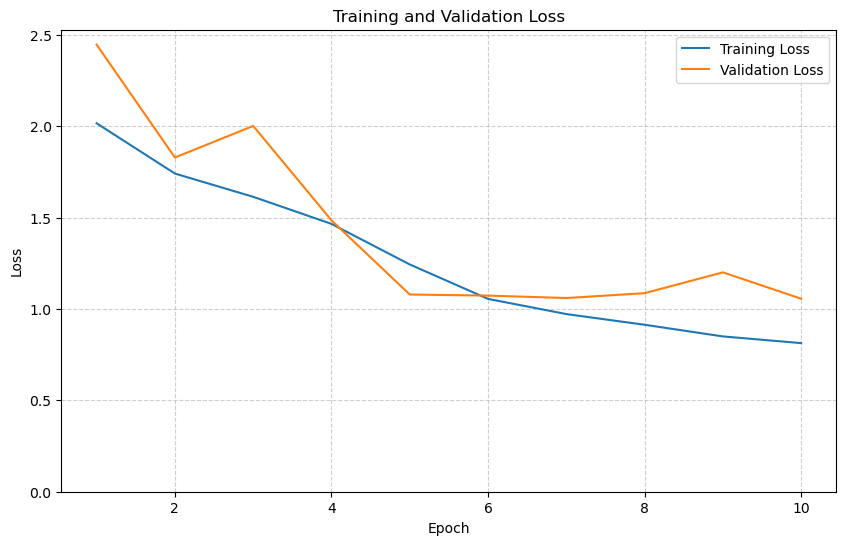

In [79]:
model_timestamp = '2024-12-23_14-28-07'
global_train_loss_df = pd.read_csv(os.path.join(eval_dir, 'ds_regression', model_timestamp, "142807_train.csv"))
global_val_loss_df = pd.read_csv(os.path.join(eval_dir, 'ds_regression', model_timestamp, "142807_val.csv"))
run_name = "soft-cloud-22"
global_loss_out_dir = os.path.join(output_dir, 'ds_regression', model_timestamp)
plot_train_and_val_loss(global_train_loss_df, global_val_loss_df, global_loss_out_dir, run_name, filename="loss_plot.png")

local model の loss の落ち方をプロット

Plot saved to: .././data/plots/ds_regression/2024-12-28_22-17-43/loss_plot.png


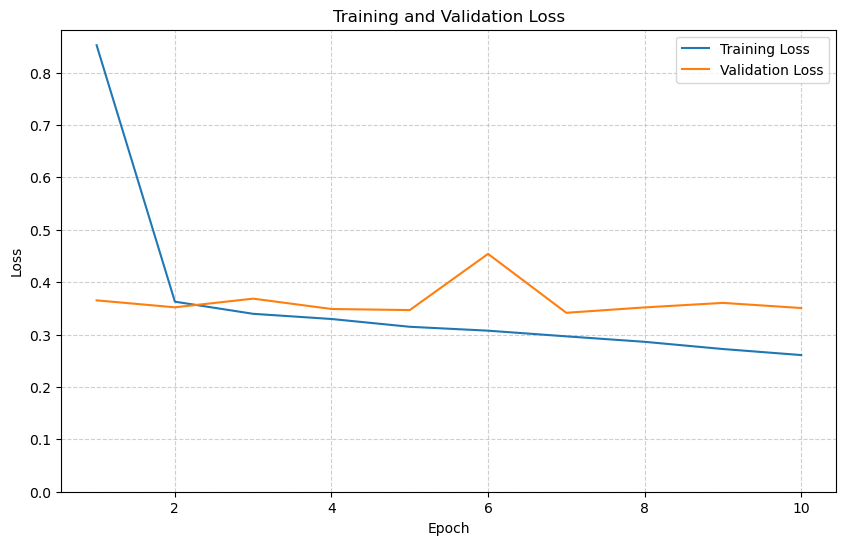

In [78]:
model_timestamp = '2024-12-28_22-17-43'
local_train_loss_df = pd.read_csv(os.path.join(eval_dir, 'ds_regression', model_timestamp, "local_train.csv"))
local_val_loss_df = pd.read_csv(os.path.join(eval_dir, 'ds_regression', model_timestamp, "local_val.csv"))
run_name = "stellar-universe-1"
local_loss_out_dir = os.path.join(output_dir, 'ds_regression', model_timestamp)
plot_train_and_val_loss(global_train_loss_df, global_val_loss_df, local_loss_out_dir, run_name, filename="loss_plot.png")

# DRD3 の結果を評価

In [30]:
drd3_timestamp = '2025-01-03_22-35-27'
drd3_eval_dir = os.path.join(eval_dir, 'ds_regression', drd3_timestamp)
drd3_result_test_path = os.path.join(eval_dir, 'ds_regression', drd3_timestamp, 'results_DRD3.csv')
drd3_plot_dir = os.path.join(ds_reg_output_dir, drd3_timestamp)

drd3_result_test_df = pd.read_csv(drd3_result_test_path)

print(drd3_result_test_df.head())

                                              SMILES     Ligand_ID Protein_ID  \
0  CC[NH+](CC(=O)Nc1ccccc1Sc1ccccc1)CC(=O)Nc1cccc...  ZINC16588640       DRD3   
1  CC1([C@H]2CC[C@@H]3[C@@H]4CC[C@@H]5CC(=O)CC[C@...  ZINC08242423       DRD3   
2             Fc1ccc(-c2nnc3n2CC[NH2+]C3)cc1C(F)(F)F  ZINC53709931       DRD3   
3  CC(C)(C)[NH+](Cc1ccccc1)Cn1nc(-c2cccc(S(=O)(=O...  ZINC03287669       DRD3   
4     CSc1ccc2nc(N(CC[NH+](C)C)C(=O)CSc3ccccc3)sc2c1  ZINC07599646       DRD3   

   Actual_Docking_Score  Predicted_Docking_Score     Error  
0             -6.597279                -7.041087  0.443808  
1             -5.493466                -5.115582  0.377883  
2             -6.826171                -6.112200  0.713971  
3             -4.910289                -5.758661  0.848372  
4             -5.760640                -5.805043  0.044403  


/tmp/ipykernel_806/1952641928.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(unique_protein_ids))


Plot saved to: .././data/plots/ds_regression/2025-01-03_22-35-27/docking_score_test_plot.png


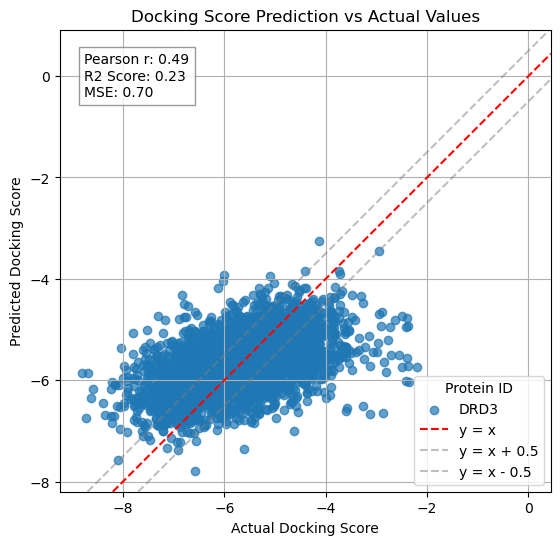

In [31]:
ds_reg_output_dir = os.path.join(output_dir, 'ds_regression', drd3_timestamp)

plot_docking_scores_vs_predictions(drd3_result_test_df, ds_reg_output_dir, filename="docking_score_test_plot.png")

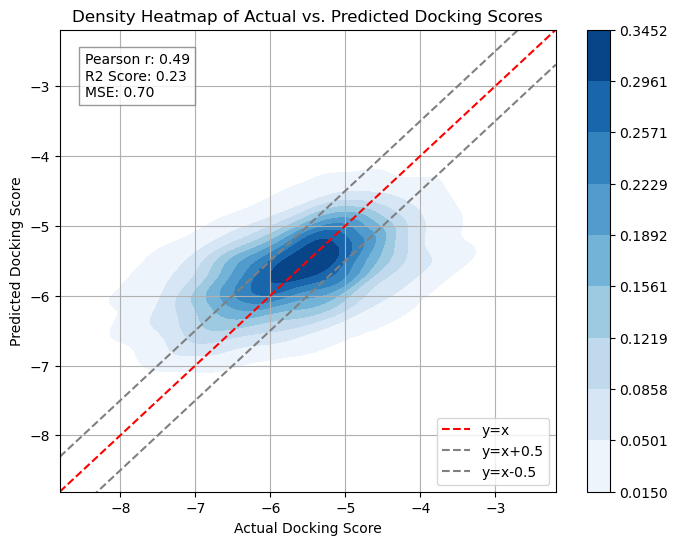

In [32]:
plot_docking_score_heatmap(
    drd3_result_test_df,
    actual_col='Actual_Docking_Score',
    predicted_col='Predicted_Docking_Score',
    x_label='Actual Docking Score',
    y_label='Predicted Docking Score',
    title='Density Heatmap of Actual vs. Predicted Docking Scores'
)

In [8]:
corr, r2 = calc_corr_r2(drd3_result_test_df)
print(f"Correlation: {corr}")
print(f"R2 Score: {r2}")

Correlation: 0.4931085236244965
R2 Score: 0.2344423950874167


# Diverse dataset

/tmp/ipykernel_806/1952641928.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(unique_protein_ids))


Plot saved to: .././data/plots/ds_regression/2024-12-28_22-17-43/AKT1_2025-01-17_16-05-23/docking_score_AKT1_plot.png


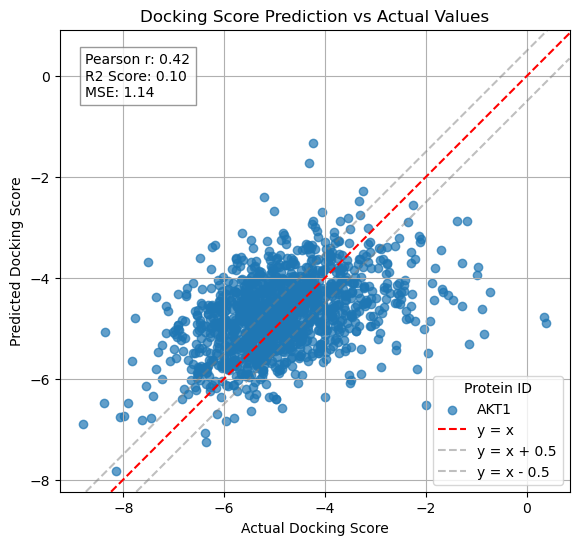

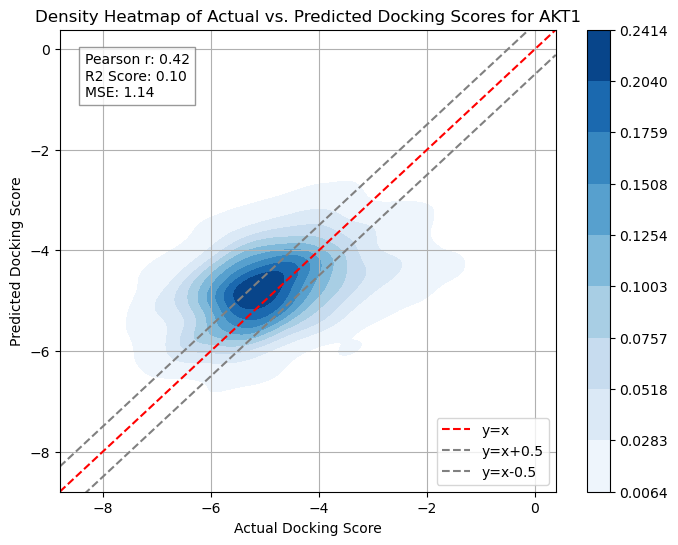

/tmp/ipykernel_806/1952641928.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(unique_protein_ids))


Plot saved to: .././data/plots/ds_regression/2024-12-28_22-17-43/AMPC_2025-01-17_16-15-24/docking_score_AMPC_plot.png


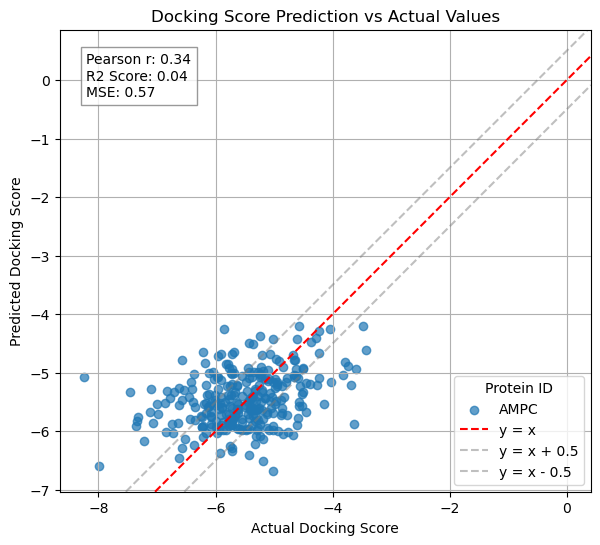

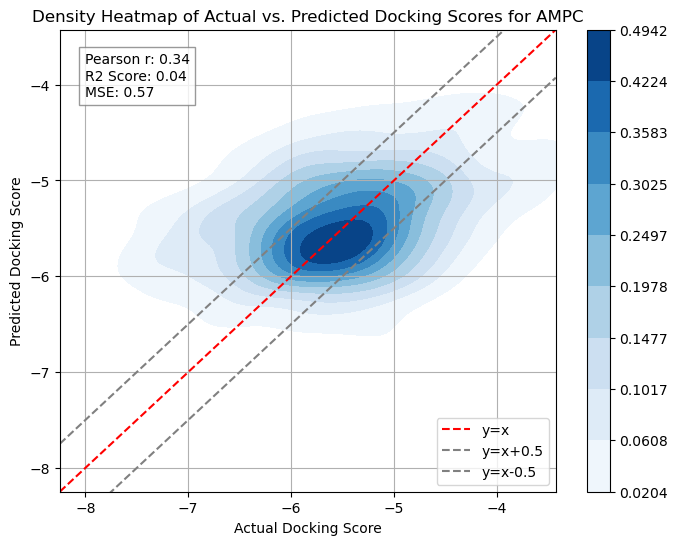

/tmp/ipykernel_806/1952641928.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(unique_protein_ids))


Plot saved to: .././data/plots/ds_regression/2024-12-28_22-17-43/CP3A4_2025-01-17_16-23-10/docking_score_CP3A4_plot.png


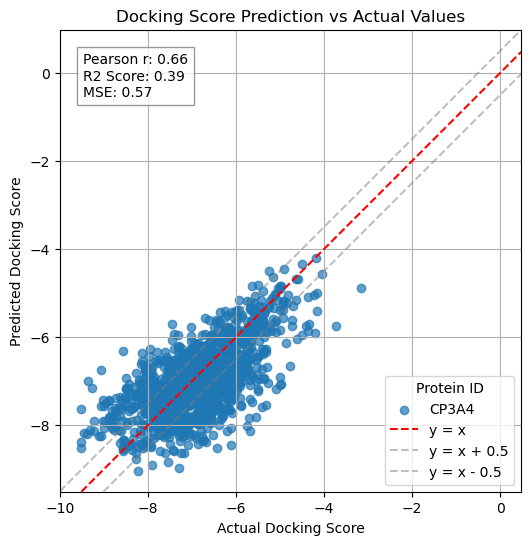

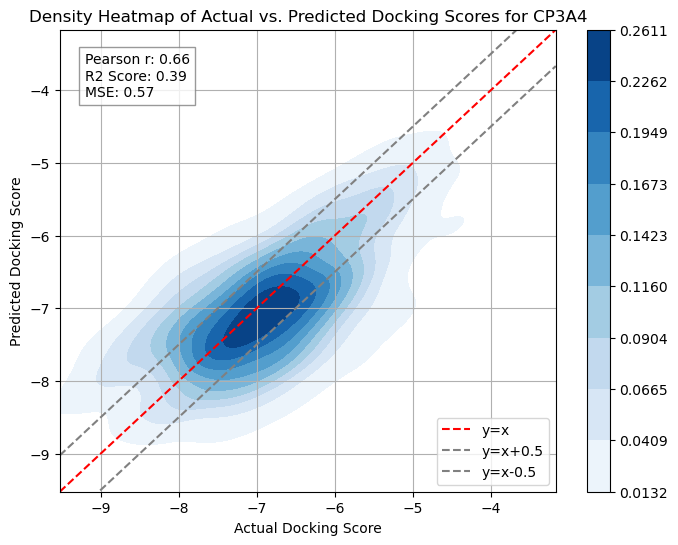

/tmp/ipykernel_806/1952641928.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(unique_protein_ids))


Plot saved to: .././data/plots/ds_regression/2024-12-28_22-17-43/CXCR4_2025-01-17_16-25-48/docking_score_CXCR4_plot.png


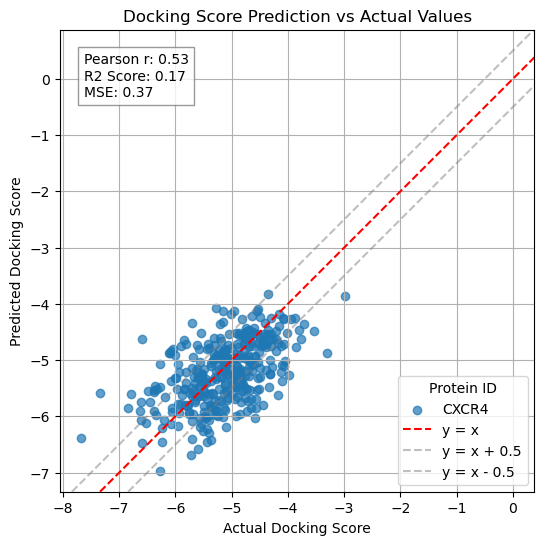

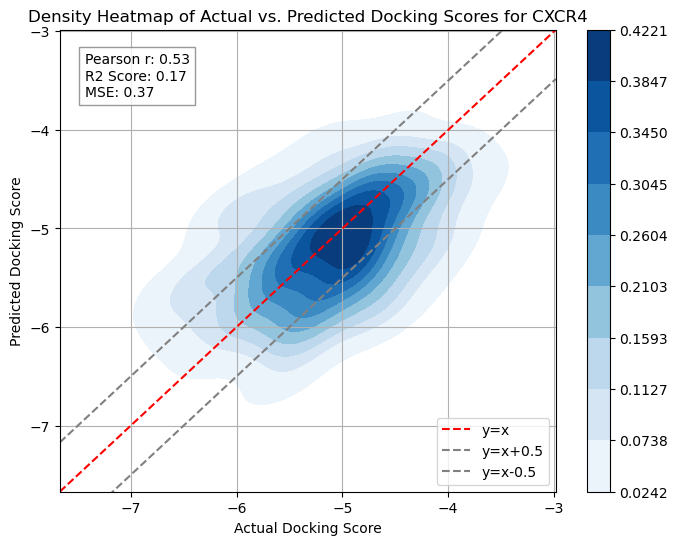

/tmp/ipykernel_806/1952641928.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(unique_protein_ids))


Plot saved to: .././data/plots/ds_regression/2024-12-28_22-17-43/GCR_2025-01-17_16-26-45/docking_score_GCR_plot.png


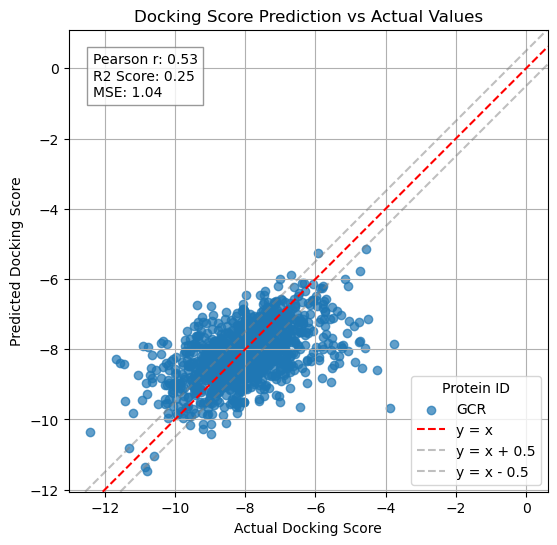

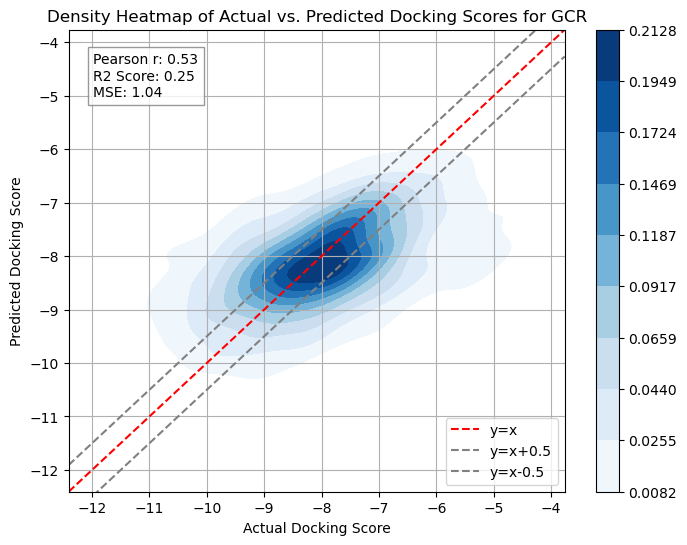

In [29]:
targets = ['AKT1', 'AMPC', 'CP3A4', 'CXCR4', 'GCR']
timestamps = ['05-23', '15-24', '23-10', '25-48', '26-45']

for target, timestamp in zip(targets, timestamps):
    timestamp = f"2025-01-17_16-{timestamp}"
    diverse_eval_dir = os.path.join(eval_dir, 'ds_regression', timestamp)
    diverse_result_path = os.path.join(eval_dir, 'ds_regression', timestamp, f"results_{target}.csv")
    diverse_plot_dir = os.path.join(ds_reg_output_dir, f"{target}_{timestamp}")
    diverse_result_df = pd.read_csv(diverse_result_path)
    plot_docking_scores_vs_predictions(diverse_result_df, diverse_plot_dir, filename=f"docking_score_{target}_plot.png")
    plot_docking_score_heatmap(
        diverse_result_df,
        actual_col='Actual_Docking_Score',
        predicted_col='Predicted_Docking_Score',
        x_label='Actual Docking Score',
        y_label='Predicted Docking Score',
        title=f'Density Heatmap of Actual vs. Predicted Docking Scores for {target}'
    )

# Schnet

In [15]:
schnet_timestamp = '2025-01-21_09-34-51'
schnet_eval_dir = os.path.join(eval_dir, 'schnet_ds_regression', schnet_timestamp)
schnet_result_test_path = os.path.join(eval_dir, 'schnet_ds_regression', schnet_timestamp, 'results_DRD3.csv')
schnet_plot_dir = os.path.join(output_dir, 'schnet_ds_regression', schnet_timestamp)
os.makedirs(schnet_plot_dir, exist_ok=True)

schnet_result_test_df = pd.read_csv(schnet_result_test_path)
print(schnet_result_test_df.head())

  SMILES Protein_ID  Actual_Docking_Score  Predicted_Docking_Score     Error
0      C       DRD3             -6.597279                -5.869133  0.728147
1      C       DRD3             -5.493466                -5.861897  0.368431
2      N       DRD3             -6.826171                -5.849463  0.976709
3      (       DRD3             -4.910289                -5.872342  0.962053
4      C       DRD3             -5.760640                -5.860489  0.099849


/tmp/ipykernel_806/1952641928.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(unique_protein_ids))


Plot saved to: .././data/plots/schnet_ds_regression/2025-01-21_09-34-51/schnet_docking_score_DRD3_plot.png


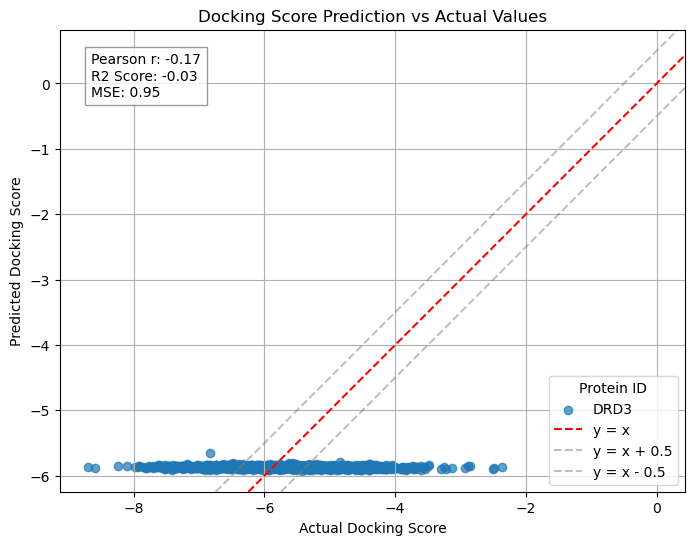

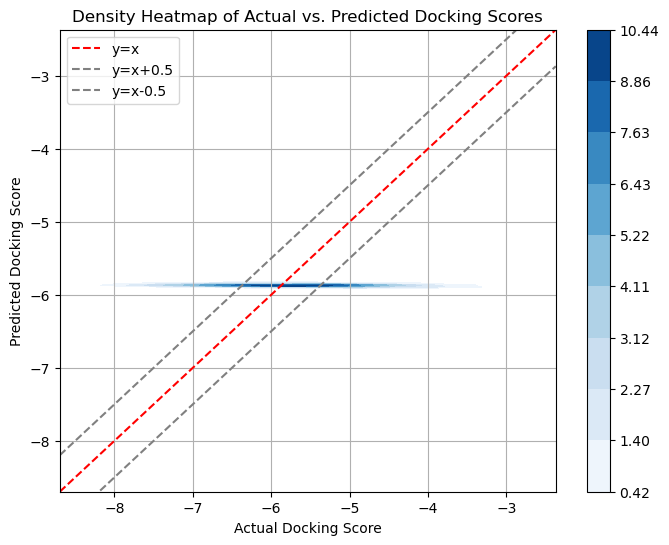

In [22]:
plot_docking_scores_vs_predictions(schnet_result_test_df, schnet_plot_dir, filename="schnet_docking_score_DRD3_plot.png")
plot_docking_score_heatmap(
    schnet_result_test_df,
    actual_col='Actual_Docking_Score',
    predicted_col='Predicted_Docking_Score',
    x_label='Actual Docking Score',
    y_label='Predicted Docking Score',
    title='Density Heatmap of Actual vs. Predicted Docking Scores'
)